Creating RawArray with float64 data, n_channels=1, n_times=48760
    Range : 0 ... 48759 =      0.000 ...   243.795 secs
Ready.
start  0.0


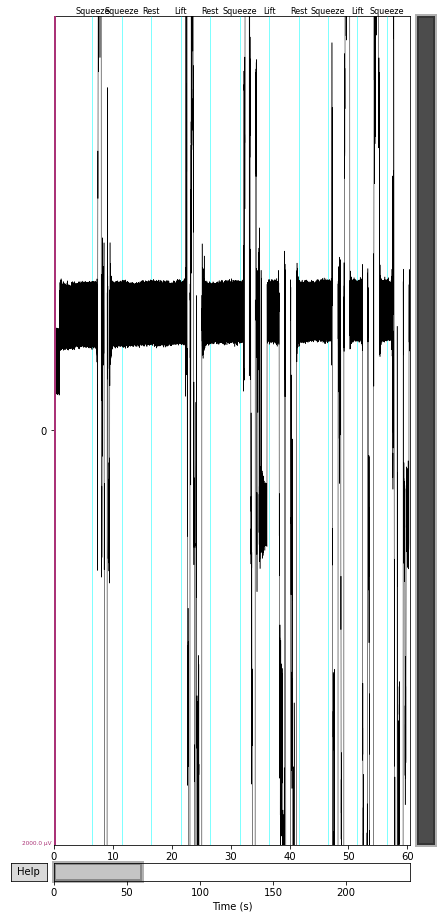

start  60.5


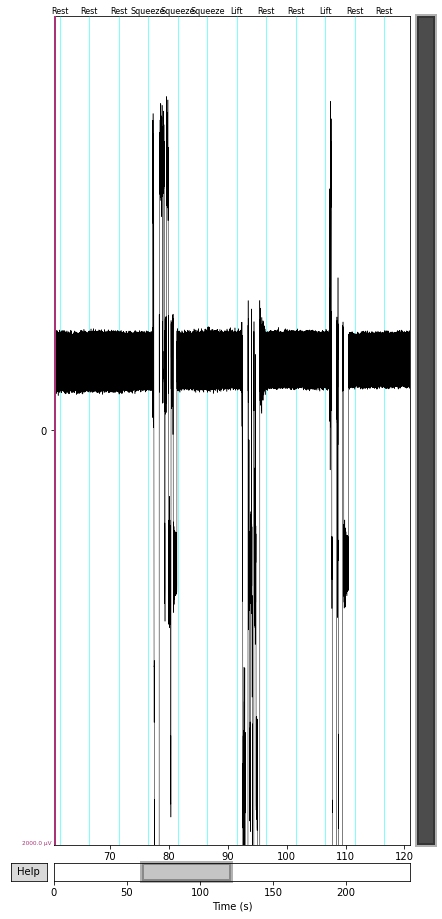

start  121.0


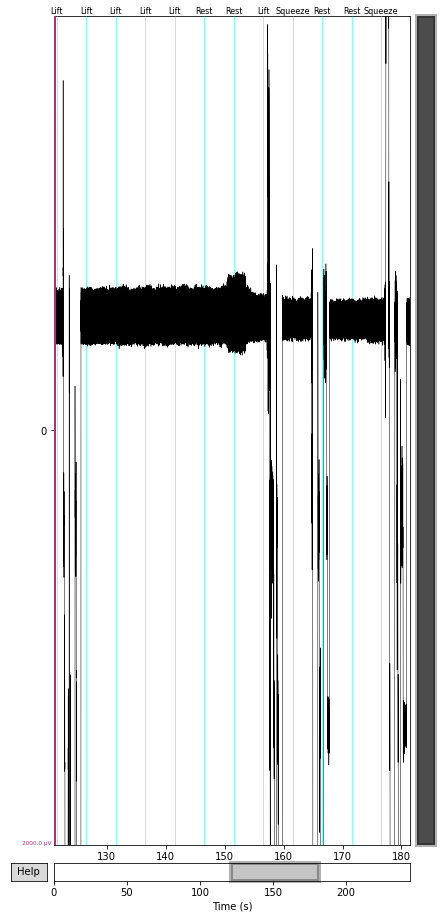

start  181.5


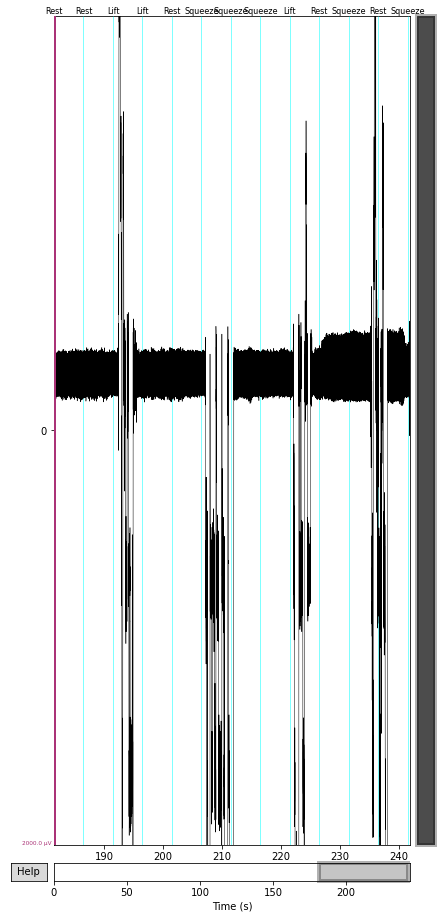

In [55]:
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class PhysioLearn:
    def __init__(self, num_channels, channel_type, eventFile=None, eventMapping=None):
        self.currentFileDf = []
        self.currentFile = None
        self.channels = num_channels
        self.channelTypes = [channel_type] * num_channels
        self.channelNames = [str(n) for n in range(num_channels)]
        self.sfreq = 200
        self.markerChannel = 14
        self.eventMapping = eventMapping
        self.events = mne.read_events(eventFile)
        self.eventsEmbeded = None
        self.raw = None
        self.info = mne.create_info(
            ch_names=self.channelNames, sfreq=self.sfreq, ch_types=self.channelTypes)

    def createEvents(self):
        i = 0
        array = []
        for sample in self.currentFileDf[self.markerChannel]:
            i = i + 1
            if sample != 0.0:
                array.append([i, 0, int(sample)])
        self.eventsEmbeded = np.array(array, dtype=int)
        df = pd.DataFrame(data=self.eventsEmbeded).to_csv('data/events-gen-eve.txt', index=None, header=None)

        

    def readFile(self, location):
        self.currentFile = DataFilter.read_file(location)
        self.currentFileDf = pd.DataFrame(np.transpose(self.currentFile))
        res = self.currentFile[1:2] / 1000000
        self.createEvents()
        self.raw = mne.io.RawArray(res, self.info)
        
        '''
        self.raw.plot(events=self.eventsEmbeded, start=30, duration=30.0,
                 event_id=self.eventMapping)
        '''
        #plt.savefig('raw.png')

    def getDataDuration(self):
        #seconds
        return len(self.currentFile[0]) / self.sfreq
         
    def createPlots(self):
        duration = round(self.getDataDuration() - 2)
        window_size = duration / 4
        for i in range(4):
            start = i * window_size
            print("start ", start)
            self.raw.plot(events=self.eventsEmbeded, start=start, duration=window_size,
                 event_id=self.eventMapping)
    
    def start(self):
        self.readFile("data/trial1.csv")
        self.createPlots()
        duration = self.getDataDuration() 
        
def main():  
    event_mapping = {'Rest': 100, 'Lift': 99, 'Squeeze': 98}
    learn = PhysioLearn(1, "emg", "data/events-eve.txt", event_mapping)
    learn.start()
    
main()